In [507]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from datetime import datetime
from datetime import timedelta
import warnings 
warnings.filterwarnings('ignore')
milk_prod = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/monthly-milk-production-pounds.csv',index_col=0,parse_dates=['Month'])
milk_prod.head()
milk_prod.columns=['milk_production']

In [508]:
milk_prod

,milk_production
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


In [509]:
print(milk_prod.size)

168


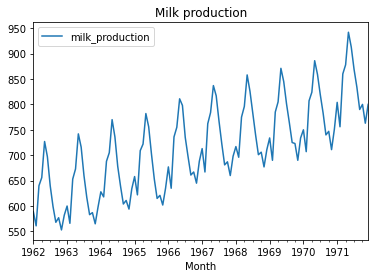

,milk_production
Month,
1971-08-01,834
1971-09-01,790
1971-10-01,800
1971-11-01,763
1971-12-01,800


In [510]:
milk_prod = milk_prod['1962-1':'1971-12']
milk_prod.plot()
plt.title('Milk production')
plt.show()
milk_prod.tail()

- Not stationary, trend and seasonality exist.
- SARIMA should be adopted

In [511]:
train_data = milk_prod[:-12]
test_data = milk_prod[-12:]

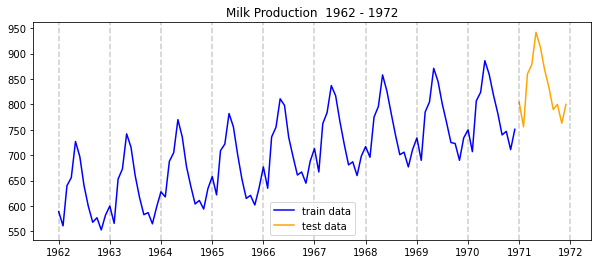

In [512]:
start_date = datetime(1962,1,1)
end_date = datetime(1973,1,1)
plt.figure(figsize=(10,4))
plt.plot(train_data,color='blue',label='train data')
plt.plot(test_data,color='orange',label='test data')
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)),color='k',alpha=0.2,linestyle='--')
plt.legend()
plt.title('Milk Production  1962 - 1972')
plt.show()

In [513]:
# H0 : it is not stationary
# Ha : it is a staionary
def adfuller_test(ts):
    result = adfuller(ts)
    labels = ['ADF test Statistics','p-value','#Lags used', 'Number of Observation Used']
    for value,label in zip(result,labels):
        print(label,':',value)
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis(H0), reject the null hypothesis. Data has no unit root and is stationary')
    else:
        print('weak evidence against the null hypothesis, fail to reject H0. time series has a unit root, indicating it is not stationary')

In [514]:
adfuller_test(train_data)

ADF test Statistics : -1.1051833945892915
p-value : 0.7130004067628737
#Lags used : 13
Number of Observation Used : 94
weak evidence against the null hypothesis, fail to reject H0. time series has a unit root, indicating it is not stationary


### Not stationary, fail to reject null hypothesis

In [515]:
train_data_diff = train_data.diff(periods=1).values
train_data_diff_seasonal = train_data.diff(periods=12).values
train_data['diff1'] = train_data_diff
train_data['diff_seasonal'] = train_data_diff_seasonal

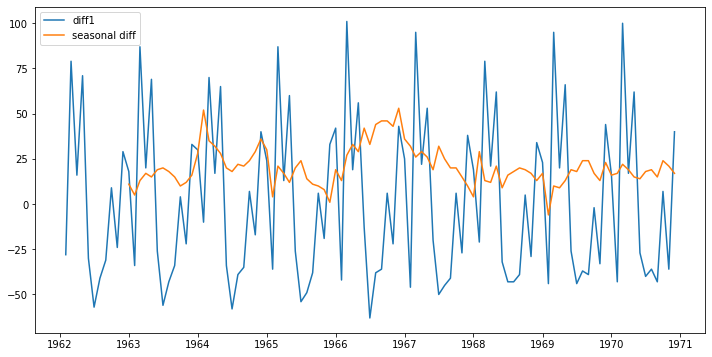

In [516]:
plt.figure(figsize=(12,6))
plt.plot(train_data.diff1,label='diff1')
plt.plot(train_data.diff_seasonal,label='seasonal diff')
plt.legend()
plt.show()

In [517]:
adfuller_test(train_data.diff1[1:])
print('--')
adfuller_test(train_data.diff_seasonal[13:])

ADF test Statistics : -3.041304453162216
p-value : 0.031213015651521472
#Lags used : 12
Number of Observation Used : 94
Strong evidence against the null hypothesis(H0), reject the null hypothesis. Data has no unit root and is stationary
--
ADF test Statistics : -2.770048933517237
p-value : 0.06268106503145021
#Lags used : 12
Number of Observation Used : 82
weak evidence against the null hypothesis, fail to reject H0. time series has a unit root, indicating it is not stationary


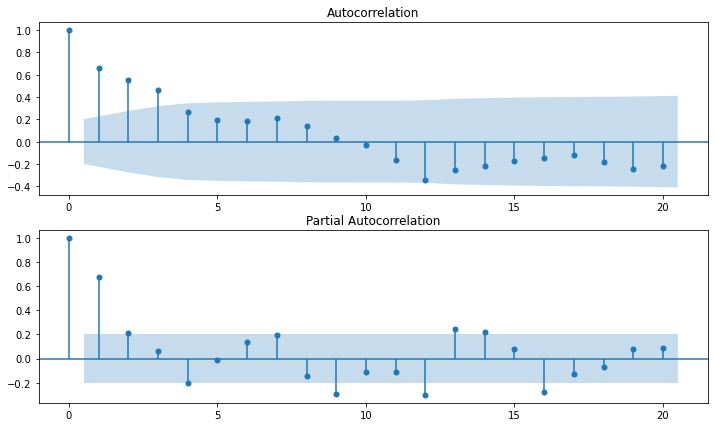

In [518]:
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(2,1,1)
plot_acf(train_data.diff_seasonal[13:],ax=ax1)
ax2 = fig.add_subplot(2,1,2)
plot_pacf(train_data.diff_seasonal[13:],ax=ax2)
plt.show()

- (p,d,q) x (P,D,Q) = (1,1,0)x (1,1,0)

In [519]:
my_order = (1,1,0)
my_seasonal_order = (1,1,1,12)
model1 = SARIMAX(train_data.milk_production,order=my_order,seasonal_order=my_seasonal_order)
model1_fit = model1.fit()

In [520]:
start_pred = len(train_data.index)
end_pred = len(train_data.index)+11
model1_pred = model1_fit.predict(start = start_pred, end = end_pred,dynamic=True)
model1_pred

1971-01-01    771.007843
1971-02-01    731.083746
1971-03-01    825.897031
1971-04-01    844.649047
1971-05-01    907.022697
1971-06-01    880.502778
1971-07-01    837.048190
1971-08-01    798.853689
1971-09-01    758.115281
1971-10-01    762.170803
1971-11-01    729.565719
1971-12-01    769.662055
Freq: MS, Name: predicted_mean, dtype: float64

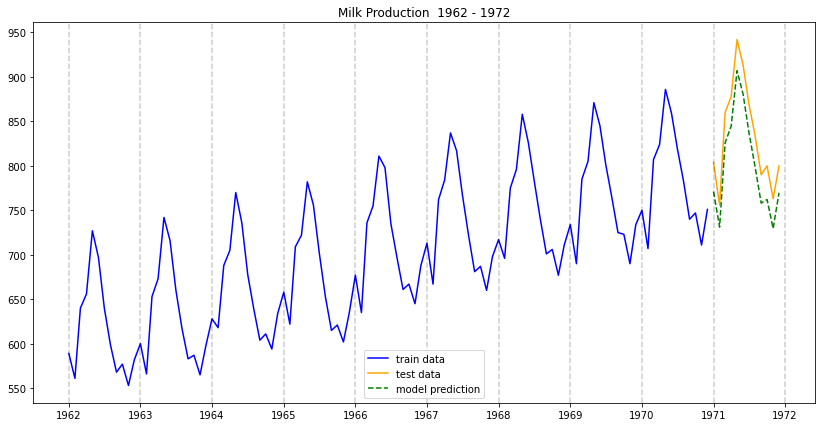

In [521]:
start_date = datetime(1962,1,1)
end_date = datetime(1973,1,1)
plt.figure(figsize=(14,7))
plt.plot(train_data.milk_production,color='blue',label='train data')
plt.plot(test_data.milk_production,color='orange',label='test data')
plt.plot(model1_pred,color='green',label='model prediction',linestyle='--')
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)),color='k',alpha=0.2,linestyle='--')
plt.legend()
plt.title('Milk Production  1962 - 1972')
plt.show()

In [533]:
residuals = test_data.values.ravel() - model1_pred.values
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.values.ravel())),4))
print('RMSE',np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 0.0394
RMSE 32.92186288300369


# Rolling forecast

In [523]:
from datetime import datetime
from datetime import timedelta
train_end = datetime(1970,12,1)
test_end = datetime(1971,12,1)
# train_data = train_data.milk_production
train_data = train_data[:train_end]

In [530]:
my_order = (1,1,0)
my_seasonal_order = (1,1,0,12)
prediction_rolling = []

# rolling prediction
for train_end in test_data.index:
    train_data_roll = milk_prod[:train_end-timedelta(days=1)].milk_production
    model = SARIMAX(train_data_roll, order = my_order, seasonal_order = my_seasonal_order)
    model_fit = model.fit()
    pred = model_fit.forecast()
    prediction_rolling.append(pred.values[0])

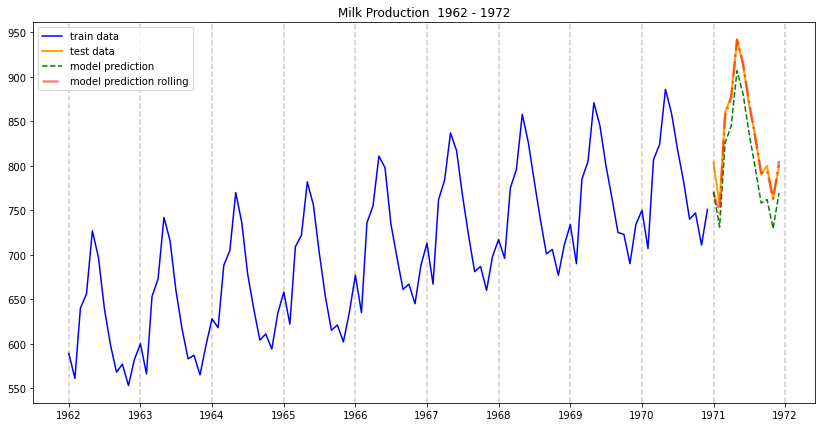

In [531]:
start_date = datetime(1962,1,1)
end_date = datetime(1973,1,1)
plt.figure(figsize=(14,7))
plt.plot(train_data.milk_production,color='blue',label='train data')
plt.plot(test_data.milk_production,color='orange',label='test data',linewidth='2')
plt.plot(model1_pred,color='green',label='model prediction',linestyle='--')
plt.plot(test_data.index,prediction_rolling,color='red',label='model prediction rolling',linestyle='-.',alpha=0.5,linewidth=2.5)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)),color='k',alpha=0.2,linestyle='--')
plt.legend()
plt.title('Milk Production  1962 - 1972')
plt.show()

In [532]:
residuals = test_data.values.ravel() - prediction_rolling
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.values.ravel())),4))
print('RMSE',np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 0.0072
RMSE 10.640030076993803
